## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from planning import a_star

%matplotlib inline

#from bresenham import bresenham

In [3]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [5]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [6]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [7]:
# Static drone altitude (meters)
drone_altitude = 5

# Minimum distance stay away from obstacle (meters)
safe_distance = 3

In [8]:
# TODO: Use `create_grid` to create a grid configuration space of
# the obstacle data.
grid = create_grid(data, drone_altitude, safe_distance)

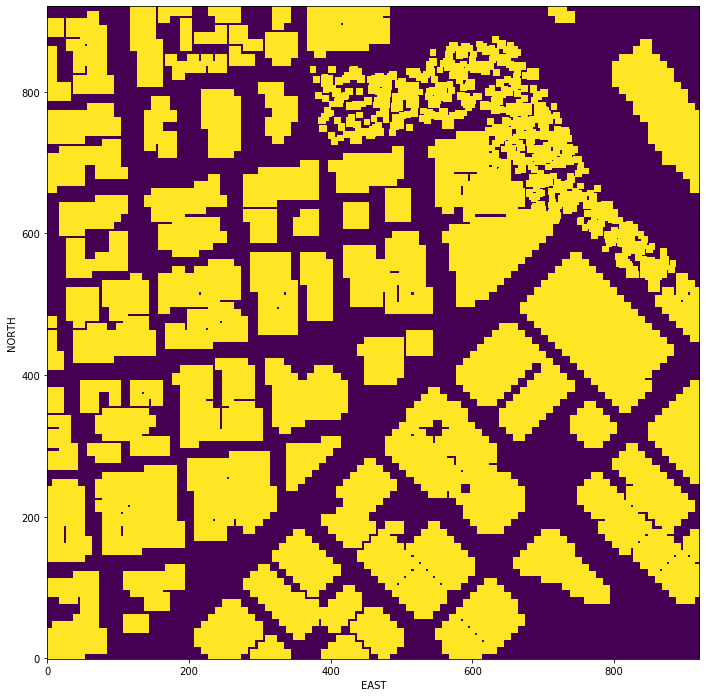

In [9]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [10]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Write a heuristic function.

In [11]:
def heuristic(p, goal, mode='euclid'):
    p = np.array(p); goal = np.array(goal)
    if mode=='euclid':
        h = np.sqrt( (p[0] - goal[0])**2 + (p[1]-goal[1])**2 )
    elif mode=='manhattan':
        h = np.abs(p[0] - goal[0]) + np.abs(p[1]-goal[1])
    else:
        h = np.linalg.norm(p - goal)
    return h

Compute the lowest cost path with `a_star`. 

In [13]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star(grid, heuristic, start_ne, goal_ne)
print(path, cost)

Found a path.
[(25, 100), (26, 100), (27, 100), (28, 100), (29, 100), (30, 100), (31, 100), (32, 100), (33, 100), (34, 100), (35, 100), (36, 100), (37, 100), (38, 100), (39, 100), (40, 100), (41, 100), (42, 100), (43, 100), (44, 100), (45, 100), (46, 100), (47, 100), (48, 100), (49, 100), (50, 100), (51, 100), (52, 100), (53, 100), (54, 100), (55, 100), (56, 100), (57, 100), (58, 100), (59, 100), (60, 100), (61, 100), (62, 100), (63, 100), (64, 100), (65, 100), (66, 100), (67, 100), (68, 100), (69, 100), (70, 100), (71, 100), (72, 100), (73, 100), (74, 100), (75, 100), (76, 100), (77, 100), (78, 100), (79, 100), (80, 100), (81, 100), (82, 100), (83, 100), (84, 100), (85, 100), (86, 100), (87, 100), (88, 100), (89, 100), (90, 100), (91, 100), (92, 100), (93, 100), (94, 100), (95, 100), (96, 100), (97, 100), (98, 100), (99, 100), (100, 100), (101, 100), (102, 100), (103, 100), (104, 100), (105, 100), (106, 100), (107, 100), (108, 100), (109, 100), (110, 100), (111, 100), (112, 100), (113

Let's plot the path!

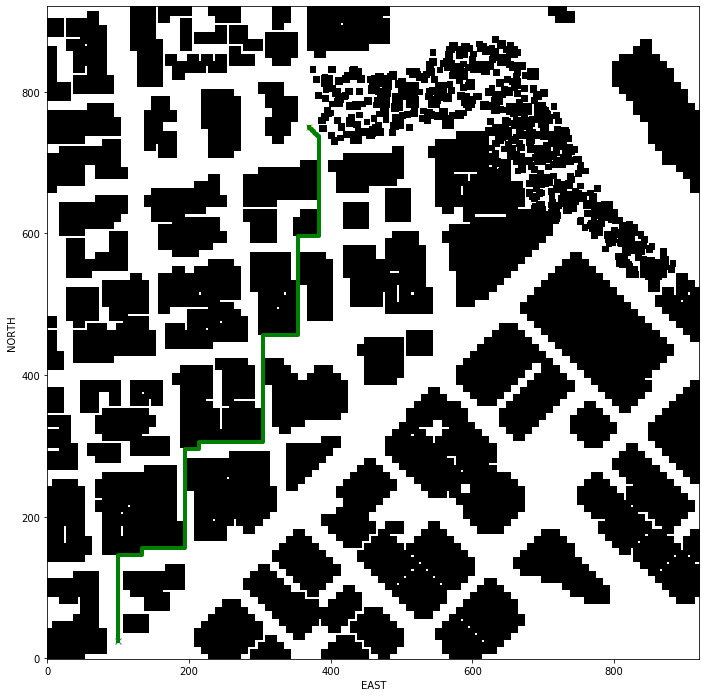

In [16]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array(path)
    plt.plot(pp[:, 1], pp[:, 0], 'g', linewidth=4)

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [17]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [2]:
def prune_path(path):
    if path is not None:
        pruned_path = [path[0]]
        # TODO: prune the path!
        for i in range(0, len(path)-2, 2):
            p1,p2,p3 = path[i], path[i+1], path[i+2]
            if collinearity_check(point(p1),point(p2),point(p3)):
                continue
            pruned_path.append(p1)
            pruned_path.append(p2)
            pruned_path.append(p3)
    else:
        pruned_path = path
        
    return pruned_path

Prune the path.

In [44]:
pruned_path = prune_path(path)
print(pruned_path)

[(25, 100), (145, 100), (146, 100), (146, 101), (146, 133), (146, 134), (147, 134), (155, 134), (156, 134), (156, 135), (156, 193), (156, 194), (157, 194), (295, 194), (296, 194), (296, 195), (296, 213), (296, 214), (297, 214), (305, 214), (306, 214), (306, 215), (306, 303), (306, 304), (307, 304), (455, 304), (456, 304), (456, 305), (456, 353), (456, 354), (457, 354), (595, 354), (596, 354), (596, 355), (596, 383), (596, 384), (597, 384), (735, 384), (736, 384), (736, 383), (736, 383), (737, 383), (737, 382), (737, 382), (738, 382), (738, 381), (738, 381), (739, 381), (739, 380), (739, 380), (740, 380), (740, 379), (740, 379), (741, 379), (741, 378), (741, 378), (742, 378), (742, 377), (742, 377), (743, 377), (743, 376), (743, 376), (744, 376), (744, 375), (744, 375), (745, 375), (745, 374), (745, 374), (746, 374), (746, 373), (746, 373), (747, 373), (747, 372), (747, 372), (748, 372), (748, 371), (748, 371), (749, 371), (749, 370)]


Replot the path, it will be the same as before but the drone flight will be much smoother.

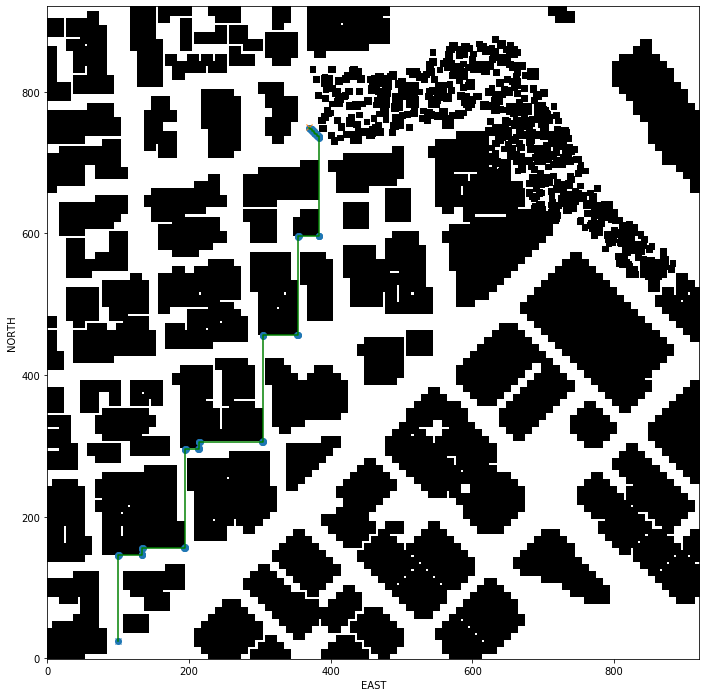

In [45]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

In [47]:
len(path), len(pruned_path)

(1024, 79)